# Planejamento da solução

-- Objetivo do problema: Previsão do primeiro destino que um novo usuário irá escolher

- Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )
            
           Gross Revenue = ( Fee*Numero cliente ) - CAC 

#
-- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**
        
--- Esperado 16 ciclos

# 0.0 Imports

In [1]:
import random
import pickle
import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib       import pyplot as plt
from pycorrcat        import pycorrcat
from pandas_profiling import ProfileReport

from imblearn          import combine
from category_encoders import TargetEncoder, one_hot
from sklearn           import model_selection as ms
from sklearn           import preprocessing   as pp
from sklearn.utils     import class_weight
from sklearn           import metrics         as me
from scikitplot        import metrics         as mt
from boruta            import BorutaPy

from lightgbm          import LGBMClassifier
from keras             import models          as ml
from keras             import layers          as la
from keras.callbacks   import EarlyStopping
from keras.optimizers  import SGD

f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()
    

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv', low_memory=False)
df_sessions = pd.read_csv('../data/raw/sessions.csv', low_memory=False)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1 Data Dimension

In [6]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 213451
number of cols: 16


In [7]:
print(f'number of rows: {df_sessions.shape[0]}')
print(f'number of cols: {df_sessions.shape[1]}')

number of rows: 10567737
number of cols: 6


## 1.2 Data Types

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [10]:
df1.isna().sum() / len(df1)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.583
gender                    0.000
age                       0.412
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.028
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64

In [11]:
df_sessions.isna().sum() / len(df_sessions)

user_id         0.003
action          0.008
action_type     0.107
action_detail   0.107
device_type     0.000
secs_elapsed    0.013
dtype: float64

## 1.4 Replace NA

In [12]:
# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].astype('int64').mean()
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3% 
# # action - 0.7% 
# # action_type - 11% 
# # action_detail - 11% 
# # secs_elapsed - 1.2%
df_sessions = df_sessions.dropna()

In [13]:
df1.isna().sum() / len(df1)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.000
gender                    0.000
age                       0.000
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.000
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64

In [14]:
df_sessions.isna().sum() / len(df_sessions)

user_id         0.000
action          0.000
action_type     0.000
action_detail   0.000
device_type     0.000
secs_elapsed    0.000
dtype: float64

## 1.5 Change Types

In [15]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype('int64')

In [16]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6 Check Balanced Data

In [17]:
df1['country_destination'].value_counts(normalize=True)

NDF     0.447
US      0.392
other   0.061
FR      0.030
IT      0.016
GB      0.014
ES      0.014
CA      0.009
DE      0.007
NL      0.005
AU      0.004
PT      0.001
Name: country_destination, dtype: float64

## 1.7 Descriptive Statistical

In [18]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop('user_id', axis=1)
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1 Numerical Attributes - Users

In [19]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
age,16.000,115.000,99.000,37.406,34.000,13.940,2.090,6.516
signup_flow,0.000,25.000,25.000,2.520,0.000,6.605,2.706,5.928


### 1.7.2 Numerical Attributes - Sessions

In [20]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes_sessions.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.000,1799977.000,1799977.000,19961.825,1369.000,88849.393,11.138,154.843


### 1.7.3 Categorical Attributes - Users

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.7.4 Categorical Attributes - Sessions

In [22]:
cat_attributes_sessions.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


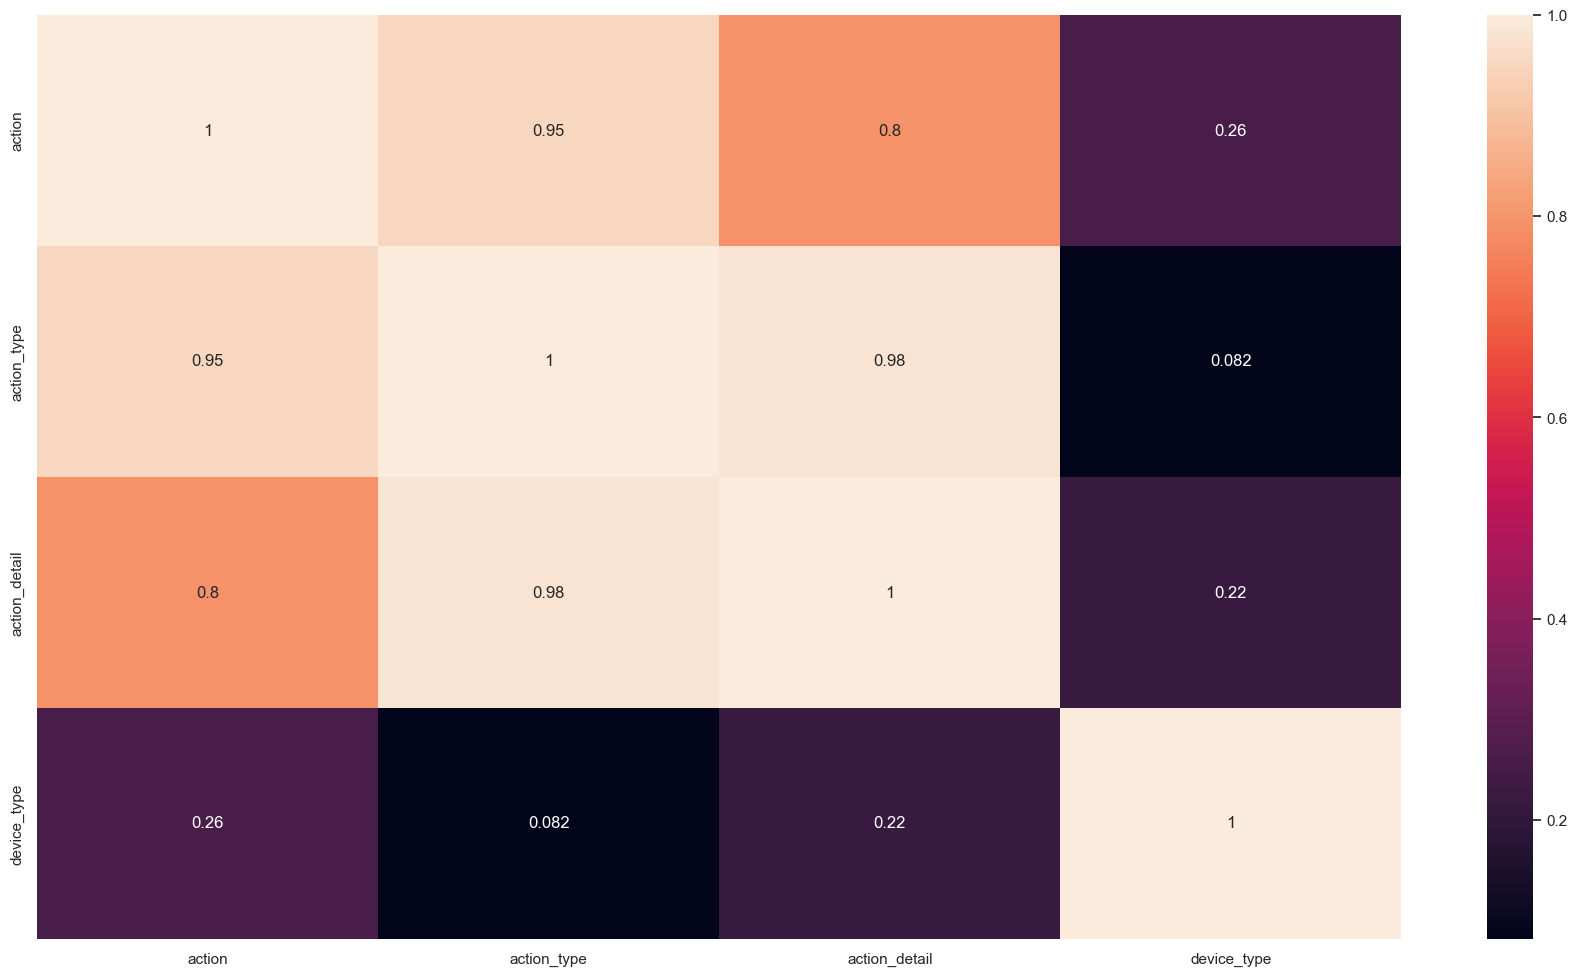

In [23]:
# Cramer V correlation
d = pycorrcat.corr_matrix(cat_attributes_sessions, ['action', 'action_type', 'action_detail', 'device_type'])
sns.heatmap(d, annot=True);

# 2.0 Data Filtering

In [24]:
df2 = df1.copy()

## 2.1. Filtering Rows

In [25]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df2 = df2[( df2['age'] > 15 ) & ( df2['age'] < 120 )]

# 3.0 Feature Engineering

In [26]:
df3 = df2.copy()

In [27]:
 # days from first active up to first booking
df3['first_active'] = pd.to_datetime(df3['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df3['days_from_first_active_until_booking'] = (df3['date_first_booking'] - df3['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df3['days_from_first_active_until_account_created'] = (df3['date_account_created'] - df3['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df3['days_from_account_created_until_first_booking'] = (df3['date_first_booking'] - df3['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df3['year_first_active'] = df3['first_active'].dt.year

# month first active
df3['month_first_active'] = df3['first_active'].dt.month

# day first active
df3['day_first_active'] = df3['first_active'].dt.day

# day of week first active
df3['day_of_week_first_active'] = df3['first_active'].dt.dayofweek

# week of year first active
df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df3['year_first_booking'] = df3['date_first_booking'].dt.year

# month first booking
df3['month_first_booking'] = df3['date_first_booking'].dt.month

# day first booking
df3['day_first_booking'] = df3['date_first_booking'].dt.day

# day of week first booking
df3['day_of_week_first_booking'] = df3['date_first_booking'].dt.dayofweek

# week of year first booking
df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df3['year_account_created'] = df3['date_account_created'].dt.year

# month  account_created
df3['month_account_created'] = df3['date_account_created'].dt.month

# day  account_created
df3['day_account_created'] = df3['date_account_created'].dt.day

# day of week  account_created
df3['day_of_week_account_created'] = df3['date_account_created'].dt.dayofweek

# week of year  account_created
df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear

C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_848\3728402332.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_active'] = df3['first_active'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_848\3728402332.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_first_booking'] = df3['date_first_booking'].dt.weekofyear
C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_848\3728402332.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year_account_created'] = df3['date_account_created'].dt.weekofyear


In [28]:
df3.isna().sum()

id                                               0
date_account_created                             0
timestamp_first_active                           0
date_first_booking                               0
gender                                           0
age                                              0
signup_method                                    0
signup_flow                                      0
language                                         0
affiliate_channel                                0
affiliate_provider                               0
first_affiliate_tracked                          0
signup_app                                       0
first_device_type                                0
first_browser                                    0
country_destination                              0
first_active                                     0
days_from_first_active_until_booking             0
days_from_first_active_until_account_created     0
days_from_account_created_until

In [29]:
df3.shape

(122636, 35)

In [30]:
# Drop original datetime
cols = ['date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active']
df3 = df3.drop(cols, axis=1)

# 4.0 Exploratory Data Analysis

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [32]:
# profile = ProfileReport(df4, title='Airbnb Booking')
# profile.to_file(output_file='../reports/airbnb_booking_statistics_after_cleaning.html')



# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

## 4.2 Bivariate Analysis

### H1. Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.
**Verdadeiro.** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

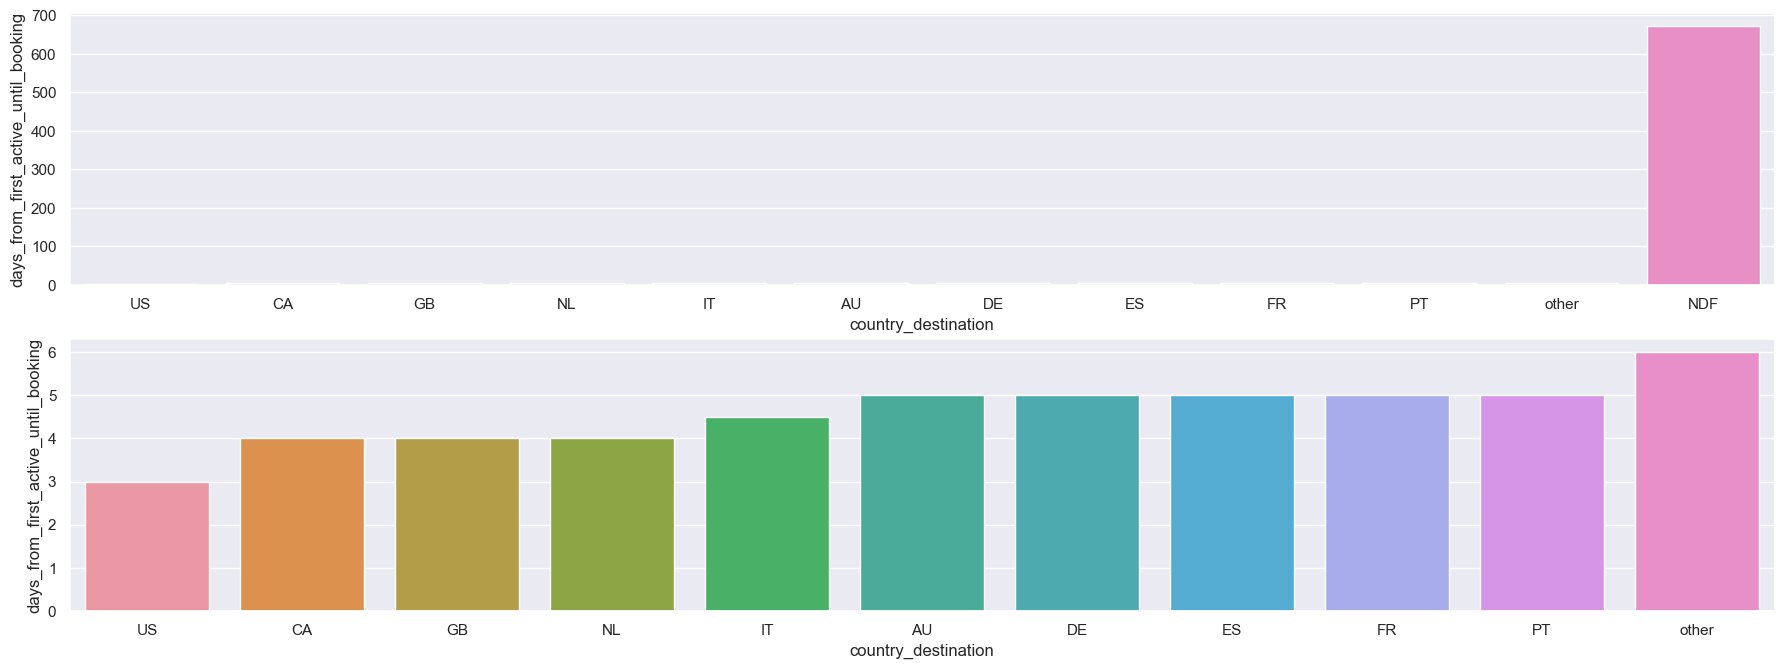

In [33]:
plt.subplot(3, 1, 1)
aux01 = df4[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values('days_from_first_active_until_booking'))

# remove outlier
plt.subplot(3, 1, 2 )
aux02 = df4[df4['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values('days_from_first_active_until_booking'));

### H2. Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.
**Verdadeira.** Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

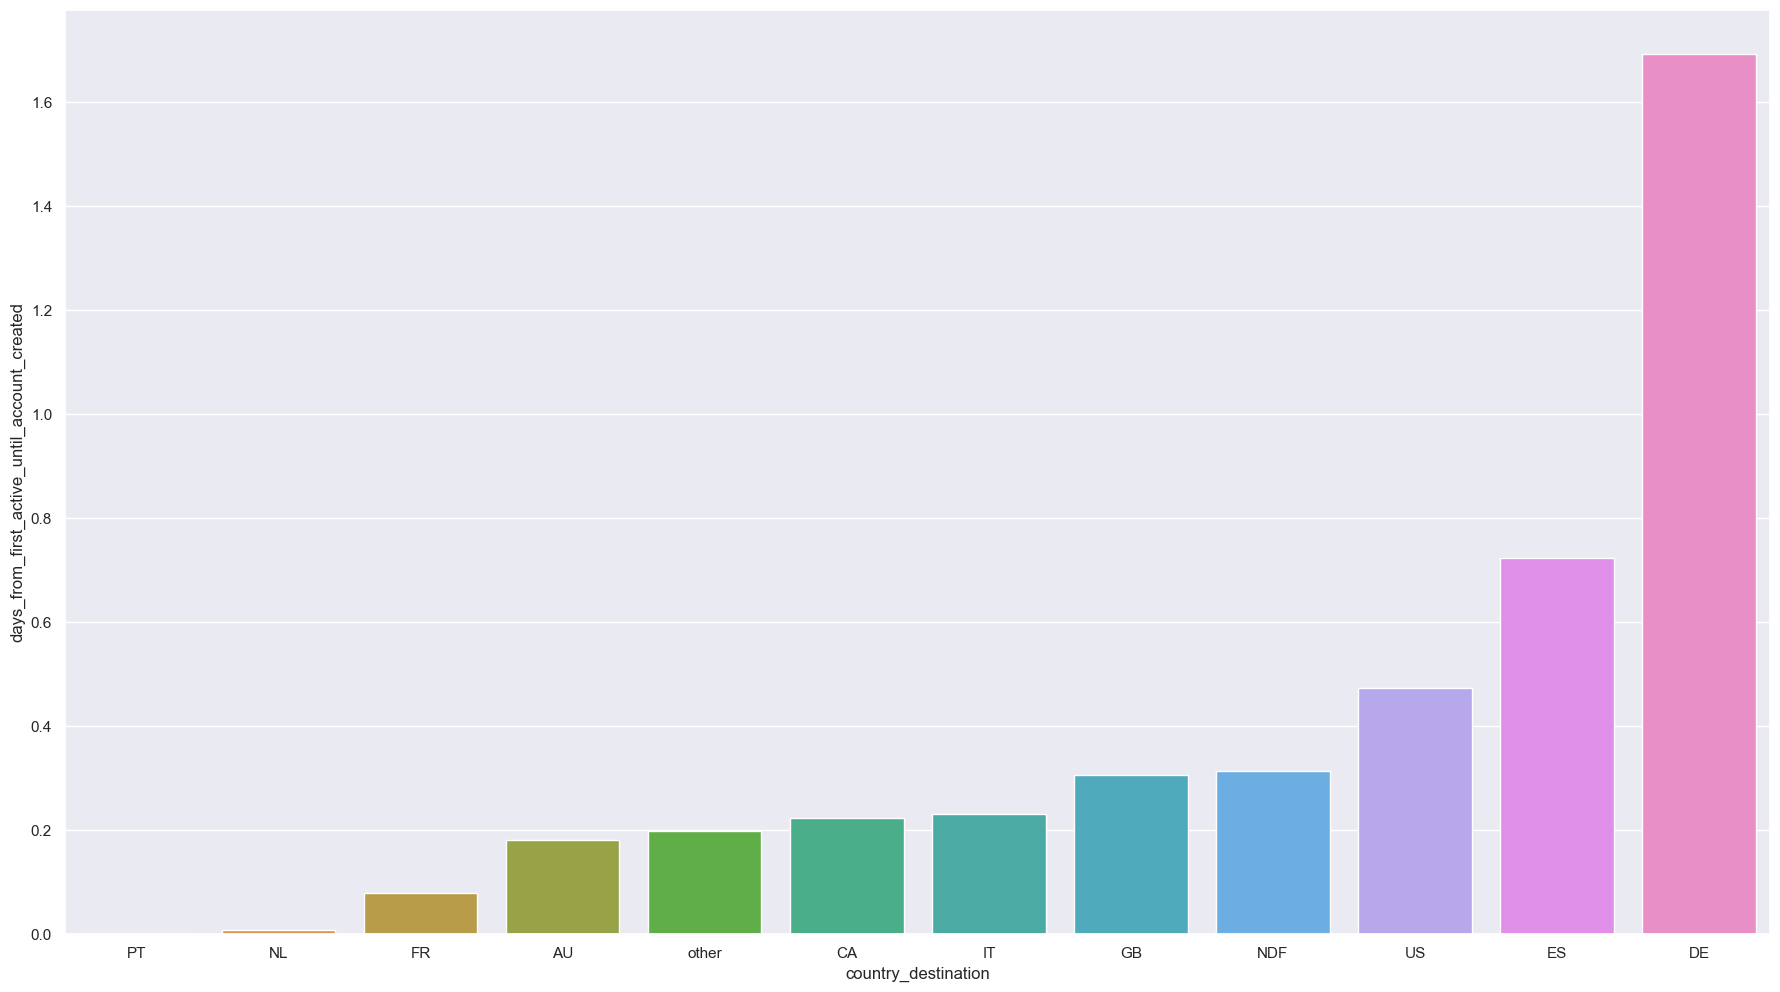

In [34]:
aux01 = df4[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values('days_from_first_active_until_account_created'));

### H3. O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.
**False.** O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

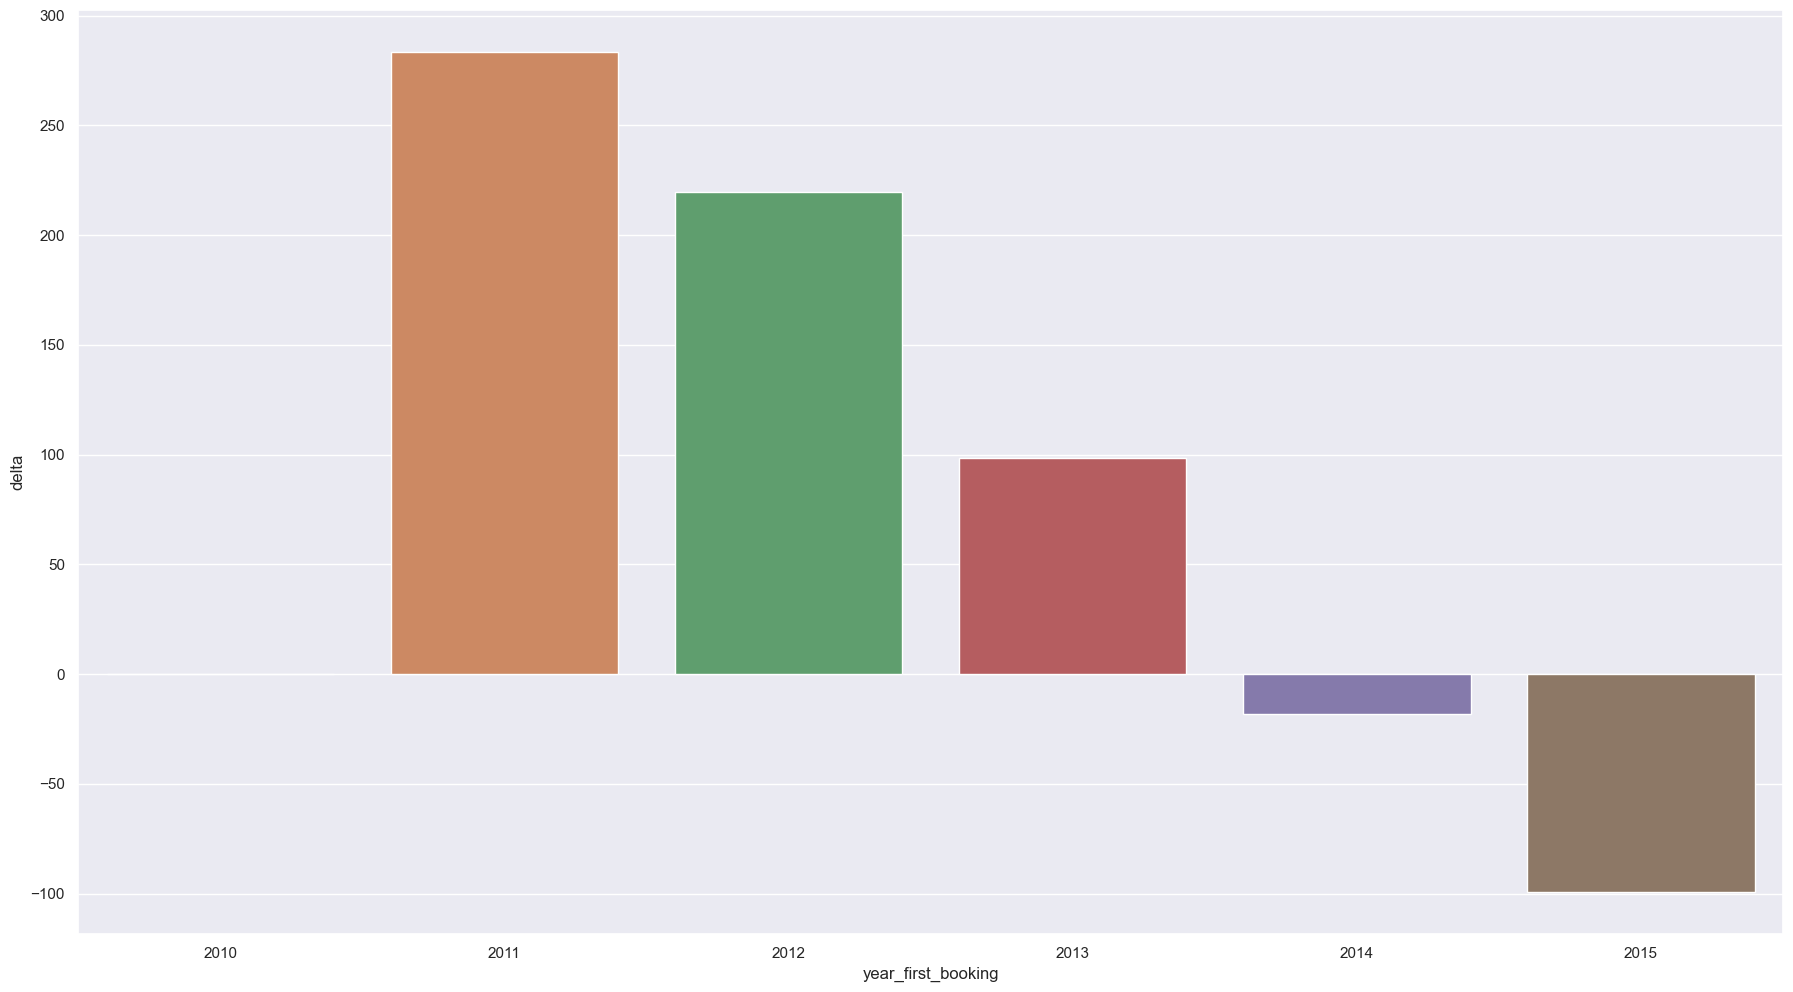

In [35]:
aux01 = df4[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby(['year_first_booking', 'month_first_booking', 'country_destination']).\
                size().reset_index().rename(columns={0:'count'})

# select only summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

sns.barplot( x='year_first_booking', y='delta', data=aux02);

### H04. Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA. 
#### H05. O canal de Marketing Google representa 40% das reservas para países fora dos USA. 
#### H06. O destino dos USA representam mais de 20% em todos os canais. 
#### H07. A idade média das pessoas é de 35 anos em todos os destinos. 
#### H08. A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90% 
#### H09. O número de reservas do Airbnb é crescente ou decrescente ao longo dos anos? 
#### H10. O número de reservas do Airbnb é crescente ao longo dos anos.

# 5.0 Data Preparation

In [163]:
df5 = df4.copy()

In [164]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5.1 Rescaling

In [165]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

#-----------------------------------Train & Test Data------------------------------------------
# age - Standardization
X_train['age'] = ss.fit_transform(X_train[['age']].values)
X_test['age'] = ss.transform(X_test[['age']].values)

# signup_flow - Robust Scaler
X_train['signup_flow'] = rs.fit_transform(X_train[['signup_flow']].values)
X_test['signup_flow'] = rs.transform(X_test[['signup_flow']].values)

# days_from_first_active_until_account_created - Robust Scaler
X_train['days_from_first_active_until_account_created'] = rs.fit_transform(X_train[['days_from_first_active_until_account_created']].values)
X_test['days_from_first_active_until_account_created'] = rs.transform(X_test[['days_from_first_active_until_account_created']].values)

# days_from_account_created_until_first_booking - Robust Scaler
X_train['days_from_account_created_until_first_booking'] = rs.fit_transform(X_train[['days_from_account_created_until_first_booking']].values)
X_test['days_from_account_created_until_first_booking'] = rs.transform(X_test[['days_from_account_created_until_first_booking']].values)

# year_account_created - MinMax Scaler
X_train['year_account_created'] = mms.fit_transform(X_train[['year_account_created']].values)
X_test['year_account_created'] = mms.transform(X_test[['year_account_created']].values)

# days_from_first_active_until_booking - Robust Scaler
X_train['days_from_first_active_until_booking'] = rs.fit_transform(X_train[['days_from_first_active_until_booking']].values)
X_test['days_from_first_active_until_booking'] = rs.transform(X_test[['days_from_first_active_until_booking']].values)

# year_first_active - MinMax Scaler
X_train['year_first_active'] = mms.fit_transform(X_train[['year_first_active']].values)
X_test['year_first_active'] = mms.transform(X_test[['year_first_active']].values)

# year_first_booking - MinMax Scaler
X_train['year_first_booking'] = mms.fit_transform(X_train[['year_first_booking']].values)
X_test['year_first_booking'] = mms.transform(X_test[['year_first_booking']].values)

## 5.2 Encoding

In [166]:
ohe = one_hot.OneHotEncoder(use_cat_names=True)
te = TargetEncoder()

# gender - One Hot Encoder
X_train_gender = ohe.fit_transform(X_train[['gender']].values)
X_train = pd.concat([X_train.drop(columns=['gender']).reset_index(), X_train_gender], axis=1)

X_test_gender = ohe.transform(X_test[['gender']].values)
X_test = pd.concat([X_test.drop(columns=['gender']).reset_index(), X_test_gender], axis=1)

# signup_method - One Hot Encoder
X_train_signup_method = ohe.fit_transform(X_train[['signup_method']].values)
X_train = pd.concat([X_train.drop(columns=['signup_method']), X_train_signup_method], axis=1)

X_test_signup_method = ohe.transform(X_test[['signup_method']].values)
X_test = pd.concat([X_test.drop(columns=['signup_method']), X_test_signup_method], axis=1)

# signup_app - One Hot Encoder
X_train_signup_app = ohe.fit_transform(X_train[['signup_app']].values)
X_train = pd.concat([X_train.drop(columns=['signup_app']), X_train_signup_app], axis=1)

X_test_signup_app = ohe.transform(X_test[['signup_app']].values)
X_test = pd.concat([X_test.drop(columns=['signup_app']), X_test_signup_app], axis=1)

# Revert Index
X_train = X_train.set_index('index')
X_test = X_test.set_index('index')
X_train.index.name = None
X_test.index.name = None

#-------------------------------------Target Encoder-------------------------------------------------
# affiliate_channel
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}

X_train['affiliate_channel'] = te.fit_transform(X_train[['affiliate_channel']].values, y_train.map(c))
X_test['affiliate_channel'] = te.transform(X_test[['affiliate_channel']].values, y_test.map(c))

# first_affiliate_tracked
X_train['first_affiliate_tracked'] = te.fit_transform(X_train[['first_affiliate_tracked']].values, y_train.map(c))
X_test['first_affiliate_tracked'] = te.transform(X_test[['first_affiliate_tracked']].values, y_test.map(c))

# Affiliate provider
X_train['affiliate_provider'] = te.fit_transform(X_train[['affiliate_provider']].values, y_train.map(c))
X_test['affiliate_provider'] = te.transform(X_test[['affiliate_provider']].values, y_test.map(c))

# first browser
X_train['first_browser'] = te.fit_transform(X_train[['first_browser']].values, y_train.map(c))
X_test['first_browser'] = te.transform(X_test[['first_browser']].values, y_test.map(c))

# first device type
X_train['first_device_type'] = te.fit_transform(X_train[['first_device_type']].values, y_train.map(c))
X_test['first_device_type'] = te.transform(X_test[['first_device_type']].values, y_test.map(c))

# language
X_train['language'] = te.fit_transform(X_train[['language']].values, y_train.map(c))
X_test['language'] = te.transform(X_test[['language']].values, y_test.map(c))

f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
f:\SamuelOliveiraAlvesd\Anaconda3\envs\airbnb_classifier\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## 5.3 Transformation

In [167]:
#-----------------------------------Train Data------------------------------------------
# week_of_year_account_created
X_train['week_of_year_account_created_sin'] = X_train['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
X_train['week_of_year_account_created_cos'] = X_train['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))

# day_of_week_first_booking
X_train['day_of_week_first_booking_sin'] = X_train['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_train['day_of_week_first_booking_cos'] = X_train['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# day_account_created
X_train['day_account_created_sin'] = X_train['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/31)))
X_train['day_account_created_cos'] = X_train['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/31)))

# day_of_week_account_created
X_train['day_of_week_account_created_sin'] = X_train['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_train['day_of_week_account_created_cos'] = X_train['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# month_first_active
X_train['month_first_active_sin'] = X_train['month_first_active'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_train['month_first_active_cos'] = X_train['month_first_active'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# day_first_active
X_train['day_first_active_sin'] = X_train['day_first_active'].apply(lambda x: np.sin(x * (2*np.pi/31)))
X_train['day_first_active_cos'] = X_train['day_first_active'].apply(lambda x: np.cos(x * (2*np.pi/31)))

# day_of_week_first_active
X_train['day_of_week_first_active_sin'] = X_train['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_train['day_of_week_first_active_cos'] = X_train['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# week_of_year_first_active
X_train['week_of_year_first_active_sin'] = X_train['week_of_year_first_active'].apply( lambda x: np.sin(x * (2*np.pi/52)))
X_train['week_of_year_first_active_cos'] = X_train['week_of_year_first_active'].apply( lambda x: np.cos(x * (2*np.pi/52)))

# month_first_booking
X_train['month_first_booking_sin'] = X_train['month_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_train['month_first_booking_cos'] = X_train['month_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# month_account_created
X_train['month_account_created_sin'] = X_train['month_account_created'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_train['month_account_created_cos'] = X_train['month_account_created'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# week_of_year_first_booking
X_train['week_of_year_first_booking_sin'] = X_train['week_of_year_first_booking'].apply( lambda x: np.sin(x * (2*np.pi/52)))
X_train['week_of_year_first_booking_cos'] = X_train['week_of_year_first_booking'].apply( lambda x: np.cos(x * (2*np.pi/52)))

#-----------------------------------Test Data------------------------------------------
# week_of_year_account_created
X_test['week_of_year_account_created_sin'] = X_test['week_of_year_account_created'].apply( lambda x: np.sin(x * (2*np.pi/52)))
X_test['week_of_year_account_created_cos'] = X_test['week_of_year_account_created'].apply( lambda x: np.cos(x * (2*np.pi/52)))

# day_of_week_first_booking
X_test['day_of_week_first_booking_sin'] = X_test['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_test['day_of_week_first_booking_cos'] = X_test['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# day_account_created
X_test['day_account_created_sin'] = X_test['day_account_created'].apply( lambda x: np.sin(x * (2*np.pi/31)))
X_test['day_account_created_cos'] = X_test['day_account_created'].apply( lambda x: np.cos(x * (2*np.pi/31)))

# day_of_week_account_created
X_test['day_of_week_account_created_sin'] = X_test['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_test['day_of_week_account_created_cos'] = X_test['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# month_first_active
X_test['month_first_active_sin'] = X_test['month_first_active'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_test['month_first_active_cos'] = X_test['month_first_active'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# day_first_active
X_test['day_first_active_sin'] = X_test['day_first_active'].apply(lambda x: np.sin(x * (2*np.pi/31)))
X_test['day_first_active_cos'] = X_test['day_first_active'].apply(lambda x: np.cos(x * (2*np.pi/31)))

# day_of_week_first_active
X_test['day_of_week_first_active_sin'] = X_test['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
X_test['day_of_week_first_active_cos'] = X_test['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# week_of_year_first_active
X_test['week_of_year_first_active_sin'] = X_test['week_of_year_first_active'].apply( lambda x: np.sin(x * (2*np.pi/52)))
X_test['week_of_year_first_active_cos'] = X_test['week_of_year_first_active'].apply( lambda x: np.cos(x * (2*np.pi/52)))

# month_first_booking
X_test['month_first_booking_sin'] = X_test['month_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_test['month_first_booking_cos'] = X_test['month_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# month_account_created
X_test['month_account_created_sin'] = X_test['month_account_created'].apply(lambda x: np.sin(x * (2*np.pi/12)))
X_test['month_account_created_cos'] = X_test['month_account_created'].apply(lambda x: np.cos(x * (2*np.pi/12)))

# week_of_year_first_booking
X_test['week_of_year_first_booking_sin'] = X_test['week_of_year_first_booking'].apply( lambda x: np.sin(x * (2*np.pi/52)))
X_test['week_of_year_first_booking_cos'] = X_test['week_of_year_first_booking'].apply( lambda x: np.cos(x * (2*np.pi/52)))


# Drop Columns
X_train = X_train.drop(columns=['week_of_year_account_created', 'day_of_week_first_booking', 'day_account_created', 'day_of_week_account_created', 
                                'month_first_active', 'day_first_active', 'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking',
                                 'month_account_created', 'week_of_year_first_booking'])
X_test = X_test.drop(columns=['week_of_year_account_created', 'day_of_week_first_booking', 'day_account_created', 'day_of_week_account_created', 
                                'month_first_active', 'day_first_active', 'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking',
                                 'month_account_created', 'week_of_year_first_booking'])

## 5.4 Balanced Dataset

In [41]:
y_train.value_counts()

NDF      43881
US       38445
other     6009
FR        2935
IT        1611
GB        1406
ES        1348
CA         851
DE         673
NL         476
AU         347
PT         126
Name: country_destination, dtype: int64

In [42]:
# # create ratio of balanced variable
# ratio_balanced =  {'NDF': 43881,
#                    'US':  38445,
#                    'other': 6*6009,
#                    'FR': 12*2935,
#                    'IT': 20*1611,
#                    'GB': 30*1406,
#                    'ES': 30*1348,
#                    'CA': 40*851,
#                    'DE': 45*673,
#                    'NL': 80*476,
#                    'AU': 85*347,
#                    'PT': 300*126}

# # define sampler
# smt = combine.SMOTETomek(sampling_strategy=ratio_balanced, random_state=42, n_jobs=-1)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(X_train.drop(columns=['id']), y_train)

# y_smt.value_counts()

In [124]:
# Saving Interim Data
# X_smt['country_destination'] = y_smt
# X_smt.to_parquet('../data/interim/X_smt_c6.parquet')

# X_smt = pd.read_parquet('../data/interim/X_smt_c6.parquet')
# y_smt = X_smt['country_destination'].copy()
# X_smt = X_smt.drop('country_destination', axis=1)

# 6.0 Feature Selection

In [168]:
df6_train = X_train.copy()

df6_test = X_test.copy()

## 6.1 Boruta selection

In [179]:
# # training and test dataset for Boruta
# x_train_f = x_train_f.values
# y_train_f = y_train_f.ravel()

# # define RandomForestRegressor
# rf = en.RandomForestClassifier(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=42).fit(x_train_f, y_train_f)

# cols_selected = boruta.support_.tolist()

In [178]:
# # best features
# cols_selected_boruta = df6_train.iloc[:, cols_selected]

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(df6_train.columns, cols_selected_boruta.columns))

# cols_selected_boruta.columns

In [177]:
# cols_selected = ['age', 'signup_flow', 'language', 'affiliate_channel',
#        'affiliate_provider', 'first_affiliate_tracked', 'first_device_type',
#        'first_browser', 'days_from_first_active_until_booking',
#        'days_from_account_created_until_first_booking', 'year_first_active',
#        'year_first_booking', 'day_first_booking', 'year_account_created',
#        '0_MALE', '0_FEMALE', '0_facebook', '0_basic', 'month_first_active_sin',
#        'month_first_active_cos', 'day_first_active_sin',
#        'day_first_active_cos', 'day_of_week_first_active_sin',
#        'day_of_week_first_active_cos', 'week_of_year_first_active_sin',
#        'week_of_year_first_active_cos', 'month_first_booking_sin',
#        'month_first_booking_cos', 'month_account_created_sin',
#        'month_account_created_cos', 'week_of_year_first_booking_sin',
#        'week_of_year_first_booking_cos', 'week_of_year_account_created_sin',
#        'week_of_year_account_created_cos', 'day_of_week_first_booking_sin',
#        'day_of_week_first_booking_cos', 'day_account_created_sin',
#        'day_account_created_cos', 'day_of_week_account_created_sin',
#        'day_of_week_account_created_cos']

# 7.0 Machine Learning Modelling

In [173]:
x_train = df6_train.drop(columns=['id'])
x_test = df6_test.drop(columns=['id'])

y_train = y_train.copy()

## 7.1 Baseline Model

In [54]:
cd_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
cd_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=cd_list, weights=cd_weights, k=k_num)

### 7.1.1 Baseline Model Performance

Accuracy: 0.3588144161774299
Accuracy: 0.08300281336471345
Accuracy: -0.00036198018096267326
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        86
          CA       0.00      0.00      0.00       213
          DE       0.01      0.01      0.01       168
          ES       0.01      0.01      0.01       337
          FR       0.03      0.03      0.03       734
          GB       0.02      0.02      0.02       352
          IT       0.02      0.02      0.02       403
         NDF       0.45      0.44      0.45     10971
          NL       0.01      0.01      0.01       119
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9612
       other       0.06      0.06      0.06      1502

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



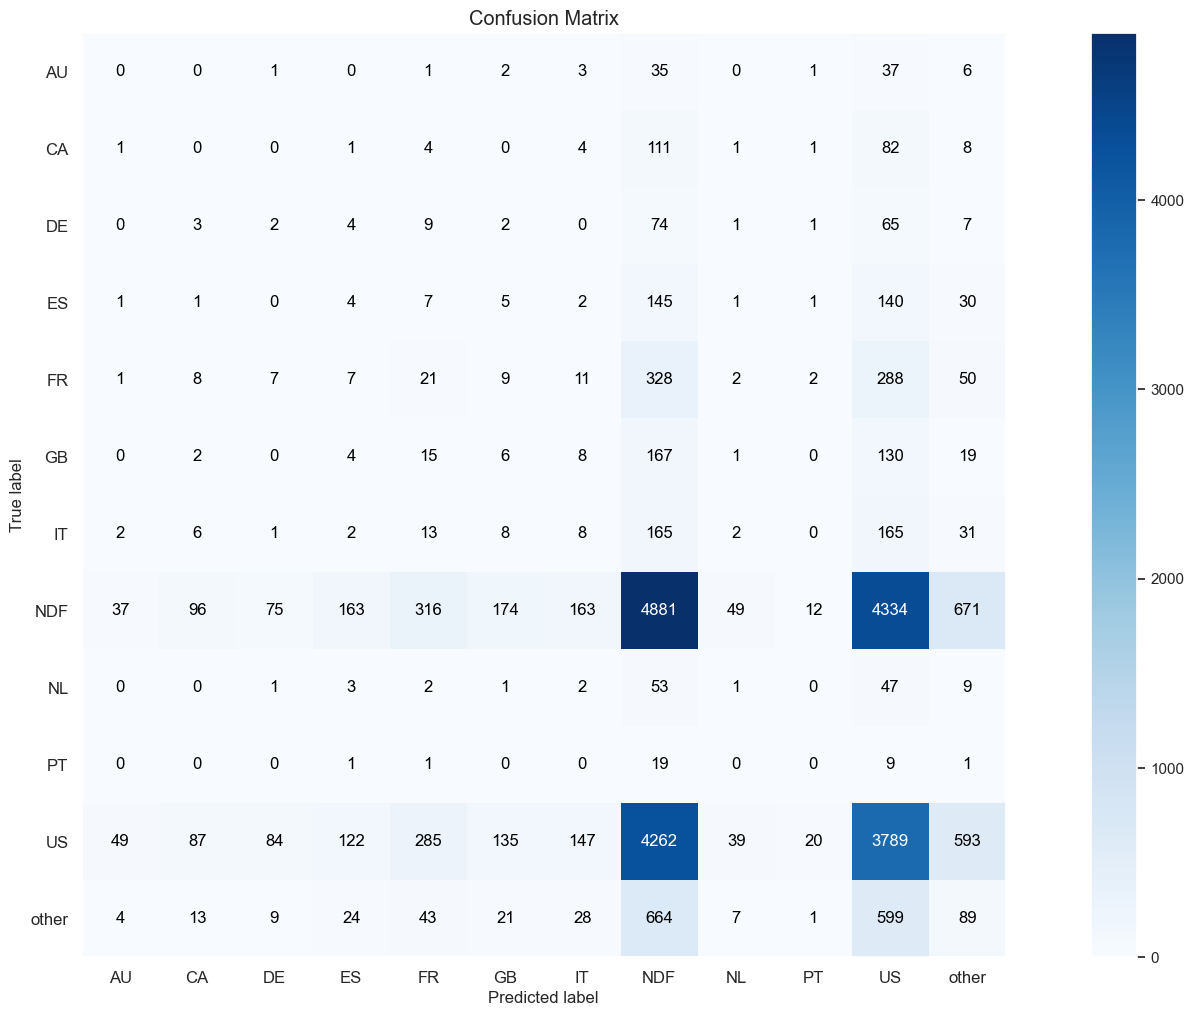

In [55]:
# Accuracy
acc_random = me.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = me.balanced_accuracy_score(y_test, yhat_random)
print(f'Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = me.cohen_kappa_score(y_test, yhat_random)
print(f'Accuracy: {kappa_random}')

# Classification report
print(me.classification_report( y_test, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False);

## 7.2 Neural Network MLP

In [176]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)

class_weights

array([23.56099904,  9.60712887, 12.14809312,  6.06503462,  2.78557638,
        5.81484116,  5.07490172,  0.1863145 , 17.17577031, 64.88624339,
        0.21265878,  1.36057026])

In [76]:
class_weights = {0:23.56099, 1:9.60712, 2:12.14809,  3:6.06503,  4:2.78557638,
        5:5.81484116,  6:5.07490172,  7:0.1863145, 8:17.17577031, 9:64.88624339,
        10:0.21265878,  11:1.36057026}

Train Acc:0.46894240379333496 - Test Acc:0.4656718969345093


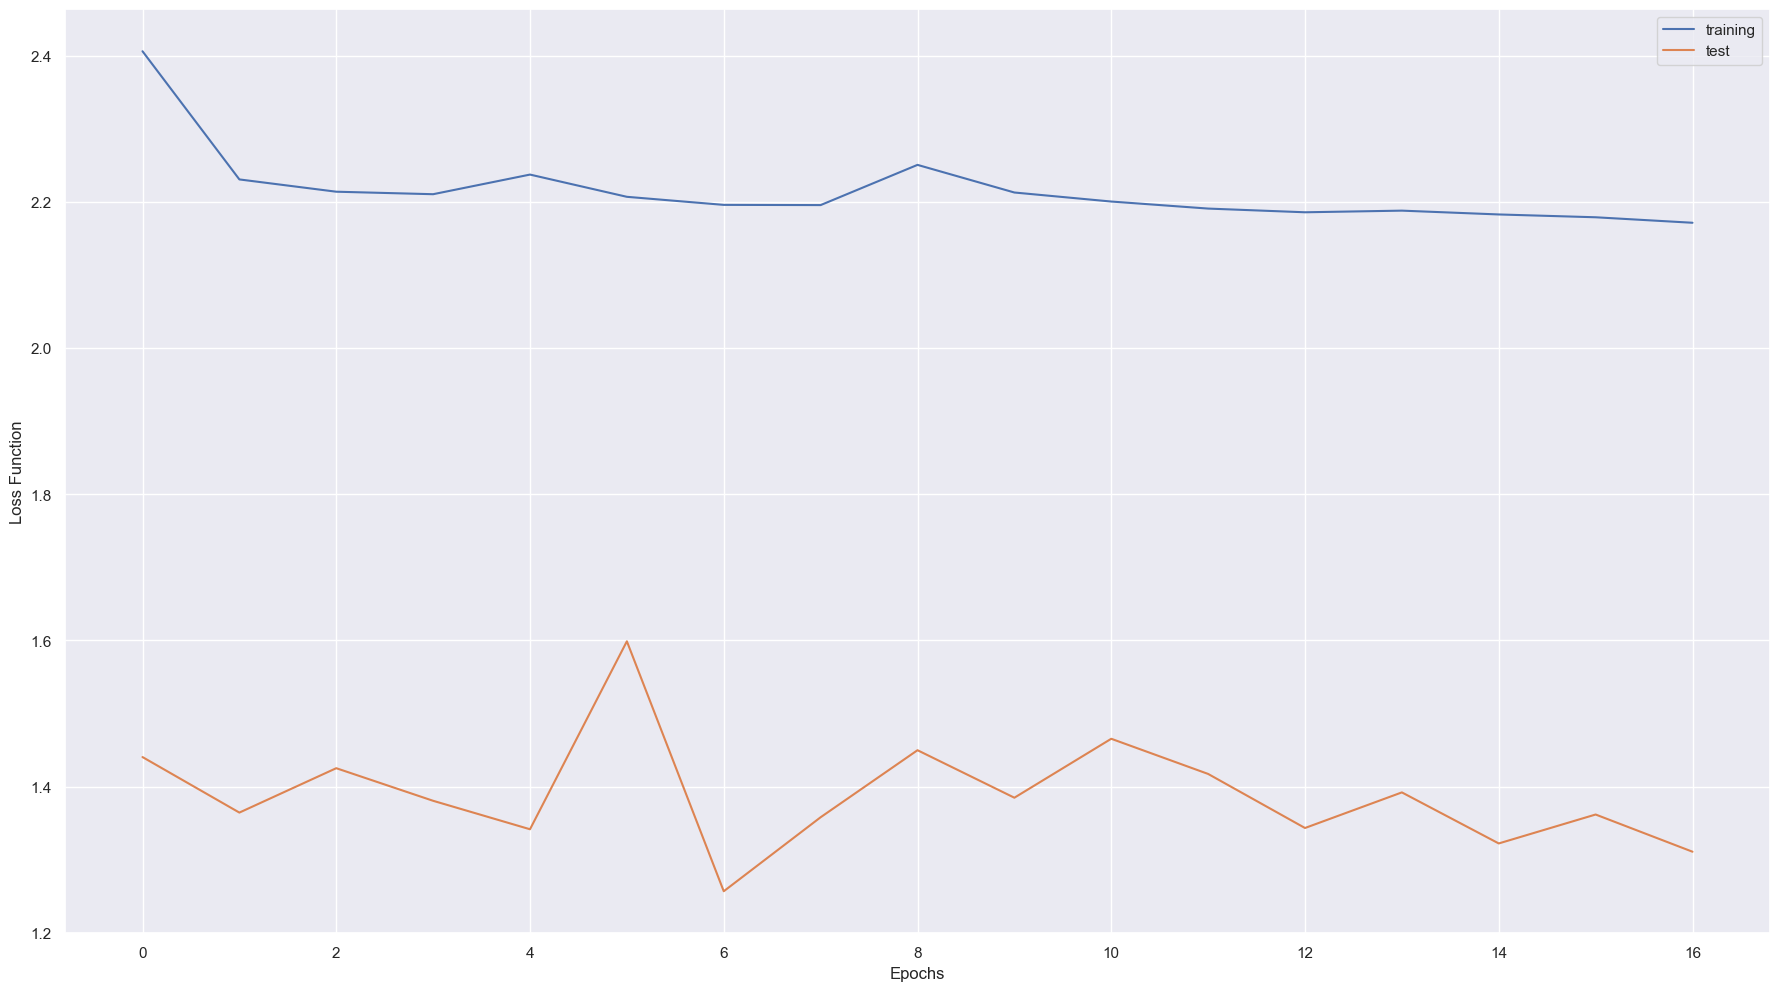

In [174]:
# Encoding variable response
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_nn = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

# model definition
model = ml.Sequential()
model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(la.Dense(12, activation='softmax'))

# model compile
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train model
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
history = model.fit(x_train, y_train_nn, validation_data=(x_test, y_test_nn), epochs=100, verbose=False, callbacks=[es], class_weight=class_weights)

_, train_acc = model.evaluate(x_train, y_train_nn, verbose=False)
_, test_acc = model.evaluate(x_test, y_test_nn, verbose=False)

print('Train Acc:{} - Test Acc:{}'.format(train_acc, test_acc))

# plot
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('Loss Function')
plt.xlabel('Epochs');

### 7.2.1 NN Performance

767/767 [==============================] - 1s 1ms/step
Accuracy: 0.46567188519243313
Balanced Accuracy: 0.1922636834799293
Kappa Score: 0.32390992136504426
              precision    recall  f1-score   support

          AU       0.01      0.48      0.02        86
          CA       0.02      0.18      0.04       213
          DE       0.02      0.12      0.04       168
          ES       0.03      0.02      0.02       337
          FR       0.07      0.03      0.05       734
          GB       0.02      0.02      0.02       352
          IT       0.04      0.20      0.06       403
         NDF       1.00      1.00      1.00     10971
          NL       0.01      0.15      0.02       119
          PT       0.01      0.03      0.01        31
          US       0.78      0.01      0.03      9612
       other       0.10      0.05      0.07      1502

    accuracy                           0.47     24528
   macro avg       0.18      0.19      0.11     24528
weighted avg       0.76      0.4

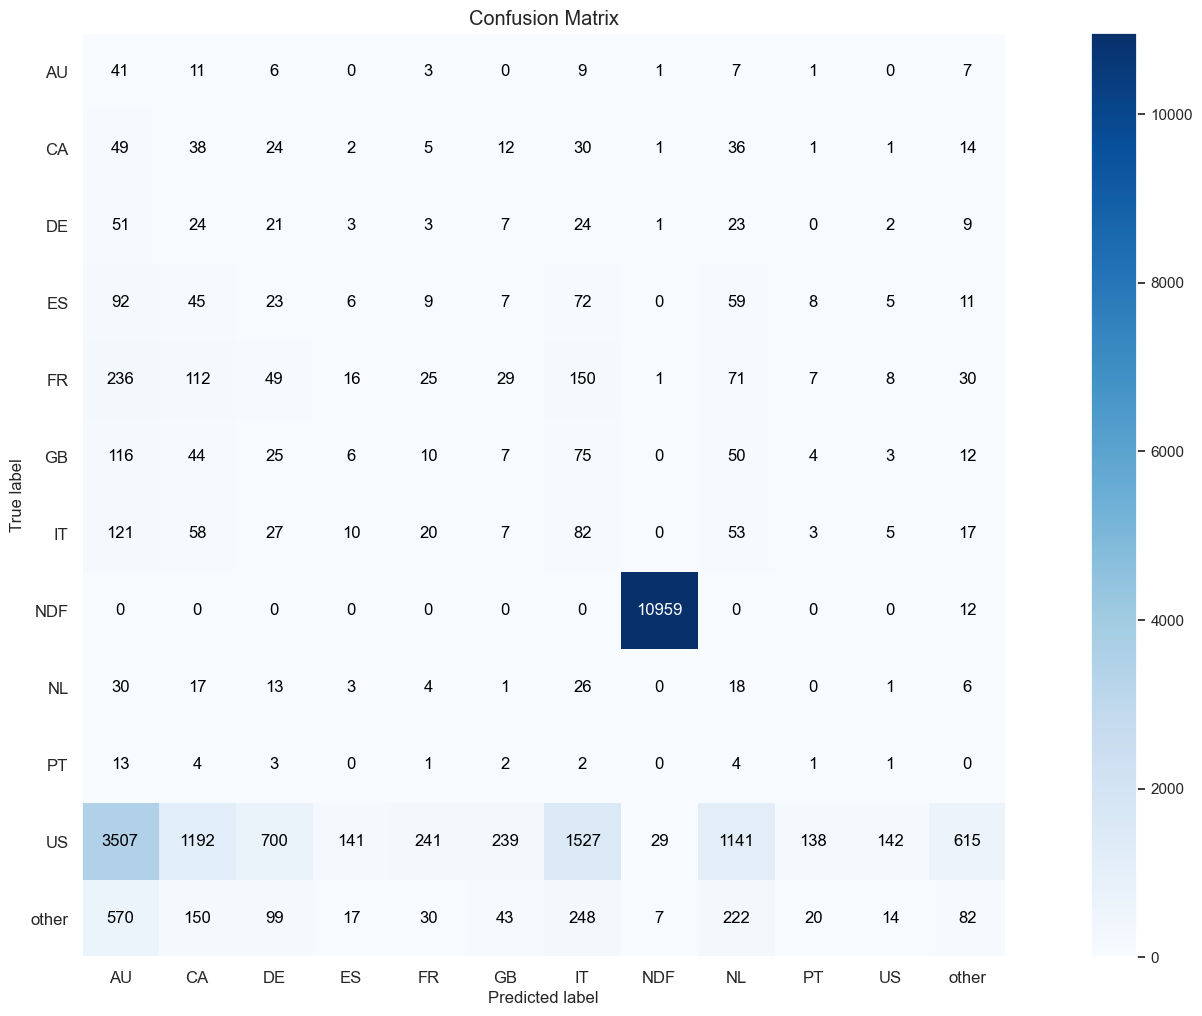

In [175]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]


# -------------------------- Metrics --------------------------
# Accuracy
acc_nn = me.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = me.balanced_accuracy_score(y_test, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = me.cohen_kappa_score(y_test, yhat_nn)
print(f'Kappa Score: {kappa_nn}')

# Classification report
print(me.classification_report(y_test, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False);

### 7.1.2 NN Performance - Cross-Validation

In [ ]:
# # generate k-fold
# num_folds = 5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# balanced_acc_list = []
# kappa_acc_list = []

# i = 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print(f'Fold Number: {i}/{num_folds}')
    
#     # get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     # target hot-encoding
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

#     # model definition
#     model = ml.Sequential()
#     model.add(la.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#     model.add(la.Dense(12, activation='softmax'))

#     # compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # training model
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

#     # prediction
#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
    
#     # prepare data
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1, -1)[0]

#     # metrics
#     ## Balanced Accuracy 
#     balanced_acc_nn = me.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
    
#     ## Kappa Metrics
#     kappa_acc_nn = me.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_acc_list.append(kappa_acc_nn)
    
#     i += 1

In [ ]:
# print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}')
# print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')

## 7.3 LGBM

In [186]:
lgbm_model = LGBMClassifier(objective='multiclass', num_class=12, metric='multi_logloss', class_weight='balanced')

lgbm_model.fit(x_train, y_train)

LGBMClassifier(class_weight='balanced', metric='multi_logloss', num_class=12,
               objective='multiclass')

### 7.3.1 LGBM Performance

Accuracy: 0.574486301369863
Balanced Accuracy: 0.19619016262914682
Kappa Score: 0.4233060113896002
              precision    recall  f1-score   support

          AU       0.01      0.12      0.03        86
          CA       0.02      0.12      0.04       213
          DE       0.02      0.08      0.03       168
          ES       0.04      0.13      0.06       337
          FR       0.08      0.17      0.11       734
          GB       0.03      0.09      0.04       352
          IT       0.04      0.11      0.06       403
         NDF       1.00      1.00      1.00     10971
          NL       0.02      0.09      0.04       119
          PT       0.00      0.00      0.00        31
          US       0.78      0.26      0.39      9612
       other       0.14      0.18      0.16      1502

    accuracy                           0.57     24528
   macro avg       0.18      0.20      0.16     24528
weighted avg       0.76      0.57      0.62     24528



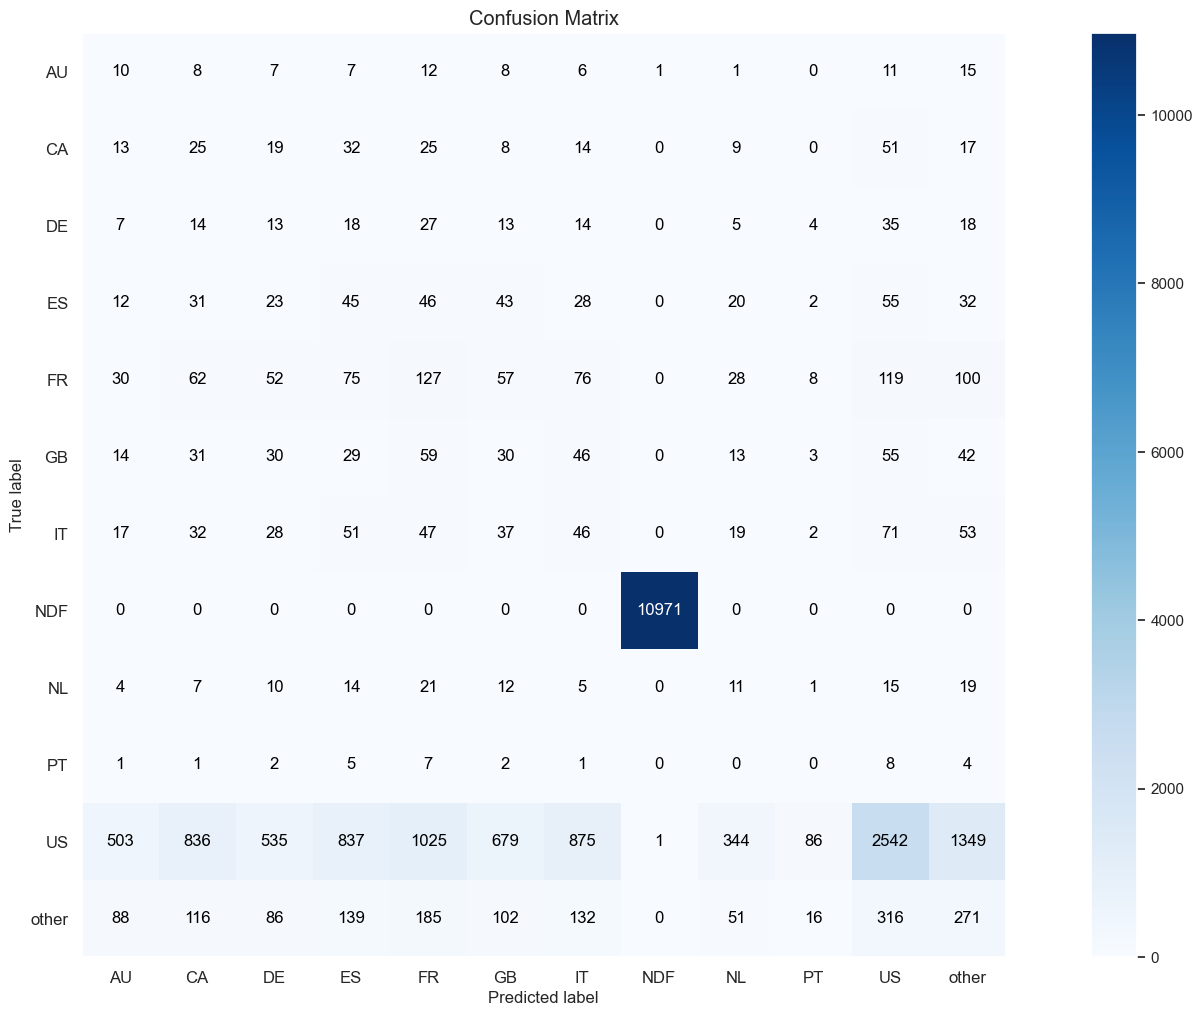

In [187]:
# prediction
yhat_lgbm = lgbm_model.predict(x_test)

# -------------------------- Metrics --------------------------
# Accuracy
acc_lgbm = me.accuracy_score(y_test, yhat_lgbm)
print(f'Accuracy: {acc_lgbm}')

# Balanced Accuracy
balanced_acc_lgbm = me.balanced_accuracy_score(y_test, yhat_lgbm)
print(f'Balanced Accuracy: {balanced_acc_lgbm}')

# Kappa Metrics
kappa_lgbm = me.cohen_kappa_score(y_test, yhat_lgbm)
print(f'Kappa Score: {kappa_lgbm}')

# Classification report
print(me.classification_report(y_test, yhat_lgbm))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize=False);